In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/billys/billys/Documents/workearly/Tensorflow/MCOILWTICO.csv')

In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [4]:
df.set_index('DATE', inplace=True)


In [5]:
#df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [6]:
df.dropna(inplace=True)

In [7]:
#df['Return'] = df['Price'].pct_change() * 100

In [8]:
df.head(), df.columns

(            Prices
 DATE              
 2010-01-01   78.33
 2010-02-01   76.39
 2010-03-01   81.20
 2010-04-01   84.29
 2010-05-01   73.74,
 Index(['Prices'], dtype='object'))

In [9]:
df.dtypes

Prices    float64
dtype: object

Text(0, 0.5, 'Price')

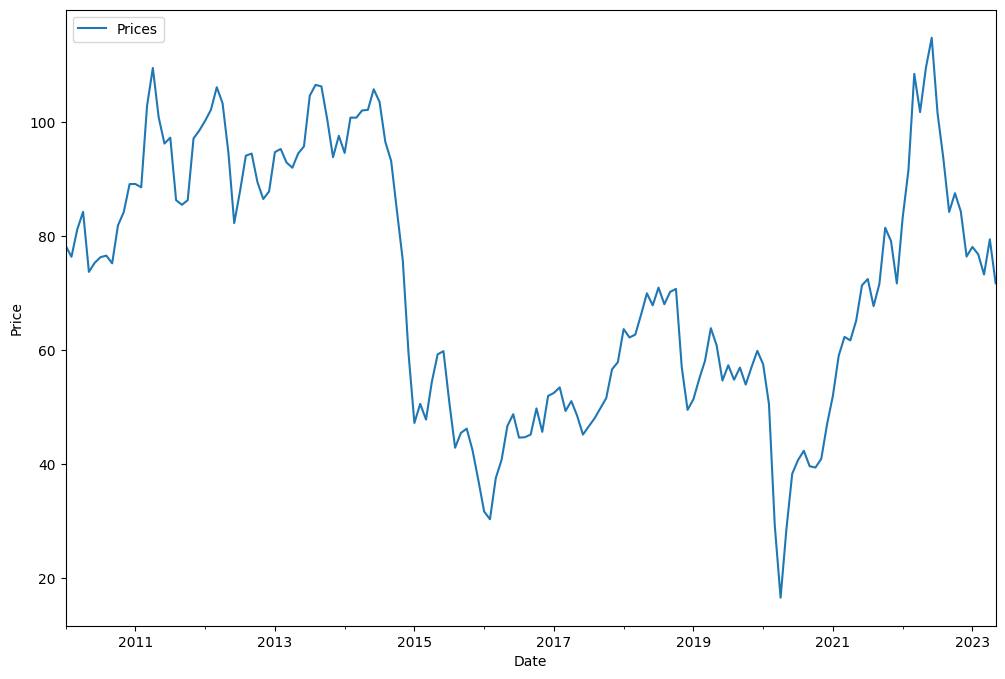

In [10]:
df.plot(figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Price')

In [11]:
len(df)

161

## Forecast 3 months into the future

In [12]:
test_size = 9

In [13]:
test_ind = len(df)- test_size

In [14]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [15]:
train

,Prices
DATE,
2010-01-01,78.33
2010-02-01,76.39
2010-03-01,81.20
2010-04-01,84.29
2010-05-01,73.74
...,...
2022-04-01,101.78
2022-05-01,109.55
2022-06-01,114.84


In [16]:
test

,Prices
DATE,
2022-09-01,84.26
2022-10-01,87.55
2022-11-01,84.37
2022-12-01,76.44
2023-01-01,78.12
2023-02-01,76.83
2023-03-01,73.28
2023-04-01,79.45
2023-05-01,71.74


# Scale Data

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
scaler.fit(train)

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2023-06-12 21:22:32.599672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 21:22:32.819732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 21:22:32.820751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 21:22:33.812319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [22]:
# Redefine to get 1 month back and then predict the next month out
length = 8
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [23]:
# What does the first batch look like?
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.62854817 0.60881066 0.65774748 0.68918506 0.58184963 0.59812799
 0.60809848 0.6109472 ]
Predict this y: 
 [[0.59711059]]


## Create the model


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
# We have only one column, df.shape[1] 
n_features = 1

In [26]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2023-06-12 21:22:47.956362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 21:22:47.958606: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### EarlyStopping and creating a Validation Generator

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [29]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=2)

In [30]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


/tmp/ipykernel_7120/1350552164.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,
2023-06-12 21:22:55.945657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


144/144 [==============================] - 2s 7ms/step - loss: 0.0468 - val_loss: 0.0085
Epoch 2/20
  1/144 [..............................] - ETA: 2s - loss: 6.6477e-04

2023-06-12 21:22:57.730565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


144/144 [==============================] - 1s 6ms/step - loss: 0.0135 - val_loss: 5.7102e-06
Epoch 3/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0117 - val_loss: 1.4578e-04
Epoch 4/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 9.8912e-05


<Axes: >

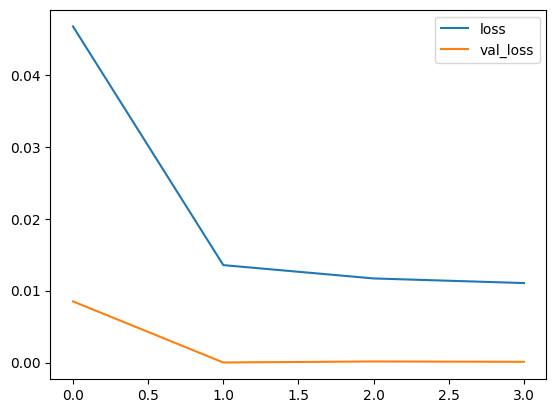

In [31]:
    losses = pd.DataFrame(model.history.history)
    losses.plot()

### Evaluate on Test Data

In [32]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1, length, n_features))
model.predict(first_eval_batch)

1/1 [==============================] - 0s 130ms/step


array([[0.8154262]], dtype=float32)

In [33]:
scaled_test[0]

array([0.68887985])

In [34]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


    ### Inverse Transformations and Compare

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions'] = true_predictions

/tmp/ipykernel_7120/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [37]:
test

,Prices,Predictions
DATE,,
2022-09-01,84.26,96.698238
2022-10-01,87.55,93.712650
2022-11-01,84.37,90.578735
2022-12-01,76.44,88.108060
2023-01-01,78.12,86.206928
2023-02-01,76.83,84.178004
2023-03-01,73.28,82.112078
2023-04-01,79.45,80.177131
2023-05-01,71.74,78.362038


<Axes: xlabel='DATE'>

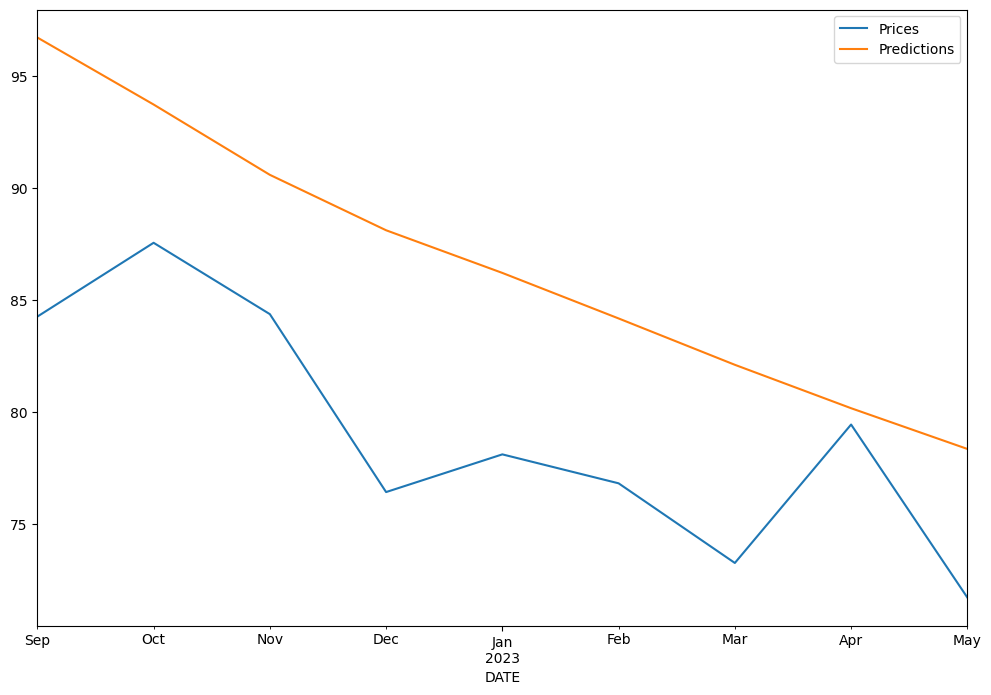

In [38]:
test.plot(figsize=(12,8))

In [39]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Prices'], test['Predictions'])
rmse = np.sqrt(mse)
rmse

8.227037361561113

# Retrain and Forecasting

In [40]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [41]:
length = 60 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [42]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


/tmp/ipykernel_7120/853647718.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)
2023-06-12 21:23:55.665501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 3s 23ms/step - loss: 0.0383
Epoch 2/8
101/101 [==============================] - 2s 23ms/step - loss: 0.0174
Epoch 3/8
101/101 [==============================] - 2s 23ms/step - loss: 0.0183
Epoch 4/8
101/101 [==============================] - 2s 21ms/step - loss: 0.0123
Epoch 5/8
101/101 [==============================] - 2s 23ms/step - loss: 0.0110
Epoch 6/8
101/101 [==============================] - 2s 23ms/step - loss: 0.0091
Epoch 7/8
101/101 [==============================] - 2s 23ms/step - loss: 0.0099
Epoch 8/8
101/101 [==============================] - 2s 23ms/step - loss: 0.0094


In [43]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 20ms/step


In [44]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [45]:
df

,Prices
DATE,
2010-01-01,78.33
2010-02-01,76.39
2010-03-01,81.20
2010-04-01,84.29
2010-05-01,73.74
...,...
2023-01-01,78.12
2023-02-01,76.83
2023-03-01,73.28


In [46]:
forecast_index = pd.date_range(start='2022-08-01',periods=periods,freq='D')

In [47]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [48]:
forecast_df

,Forecast
2022-08-01,59.080028
2022-08-02,54.924940
2022-08-03,51.204017
2022-08-04,47.844185
2022-08-05,44.893426
2022-08-06,42.373044
2022-08-07,40.279395
2022-08-08,38.594989
2022-08-09,37.291668
2022-08-10,36.334277


<Axes: >

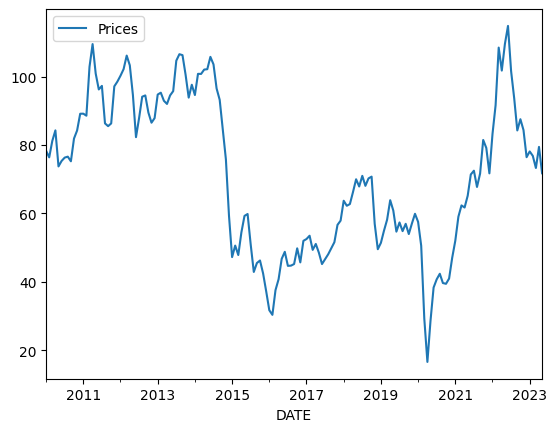

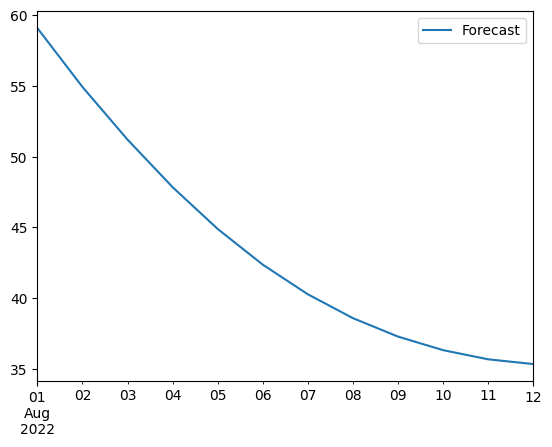

In [49]:
df.plot()
forecast_df.plot()

### Joining pandas plots

<Axes: >

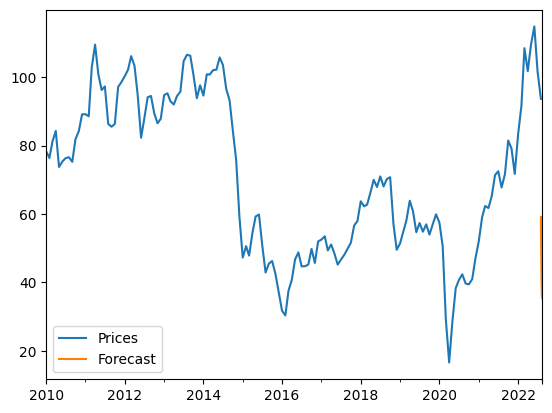

In [50]:
ax = train.plot()
forecast_df.plot(ax=ax)

In [51]:
min_date = df.index.min()
max_date = df.index.max()

print("Minimum date in the dataset:", min_date)
print("Maximum date in the dataset:", max_date)

Minimum date in the dataset: 2010-01-01 00:00:00
Maximum date in the dataset: 2023-05-01 00:00:00
